<a href="https://colab.research.google.com/github/kuretaru/topo-ml-spin-phases/blob/develop/materials/lessons/1_2_The_Physics_of_Change_(Monte_Carlo).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Base imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Theory and Algorithm

**Goal: Create realistic data.**

We can create "Order" (T=0) and "Chaos" (T=∞). But the interesting physics — and the Phase Transition we want to detect with ML — happens in between.

We need an algorithm that simulates how spins interact over time. We will use the Metropolis-Hastings Algorithm.
1. The Theory (Simplified)

In the Ising Model, every atom wants to align with its neighbors.

    Energy (E): If neighbors disagree (+1 and -1), Energy is high. Nature hates high energy.

    Temperature (T): Heat creates random noise, flipping spins even if it costs energy.

The Algorithm:

    Pick a random spin.

    Calculate: "If I flip this spin, will the total Energy drop?" (ΔE<0).

    If Yes: Flip it! (System relaxes).

    If No (Energy rises): Flip it anyway, but only with a small probability: P=e−ΔE/T.

        High T: Probability is high (Randomness wins).

        Low T: Probability is low (Order wins).

2. The Implementation (Numba)

Since Python loops are slow, usually we use a library called Numba to make them run at C++ speed. But for learning, we will use pure Numpy first (it will be slow but understandable), or a "Vectorized" approach.

To keep it simple for the "Fast Track", I will give you the core update function (handling "Periodic Boundary Conditions" — the lattice wraps around like a donut — is tricky).

In [10]:
def get_energy_change(lattice, i, j, L):
    """
    Calculates the change in energy dE if we flip the spin at (i, j).
    Uses Periodic Boundary Conditions (PBC).

    Args:
      lattice (np.ndarray):
      i (int):
      j (int):
      L (int):

    Returns: (float) Energy change
    """
    # Current spin value
    spin = lattice[i, j]

    # Neighbors (Top, Bottom, Left, Right) with wrap-around (%)
    # If i=0 (top row), i-1 becomes -1, which is the last row in Python. Perfect!
    # But explicitly: (i+1)%L handles the right/bottom edge correctly.
    neighbors = lattice[(i+1)%L, j] + lattice[(i-1)%L, j] + \
                lattice[i, (j+1)%L] + lattice[i, (j-1)%L]

    # Interaction energy change: dE = 2 * spin * sum(neighbors)
    dE = 2 * spin * neighbors
    return dE

def metropolis_step(lattice, temperature, num_steps):
    """
    Performs 'num_steps' attempts to flip spins.

    Args:
      lattice (np.ndarray):
      temperature (float):
      num_steps (int):

    Returns: (array) array of the lattice
    """
    L = lattice.shape[0]

    for _ in range(num_steps):
        # 1. Pick a random site
        i = np.random.randint(0, L)
        j = np.random.randint(0, L)

        # 2. Calculate Energy Change (dE)
        dE = get_energy_change(lattice, i, j, L)

        # 3. Decision Rule (Metropolis)
        if dE < 0:
            # Energy lowers -> Accept flip
            lattice[i, j] *= -1
        elif np.random.rand() < np.exp(-dE / temperature):
            # Energy rises -> Accept with probability exp(-dE/T)
            lattice[i, j] *= -1

    return lattice

# Tasks

**Task 1: The Evolution of Order**

    Initialize a 50x50 lattice with Random Noise (Hot start).

    Set Temperature = 1.0 (Cold environment).

    Run the loop:

        Visualize the starting state.

        Run metropolis_step for 100,000 steps.

        Visualize the state again.

        Run for another 100,000 steps.

        Visualize the final state.

    Goal: You should see the random noise slowly forming "islands" (domains) of single colors as the system "freezes".

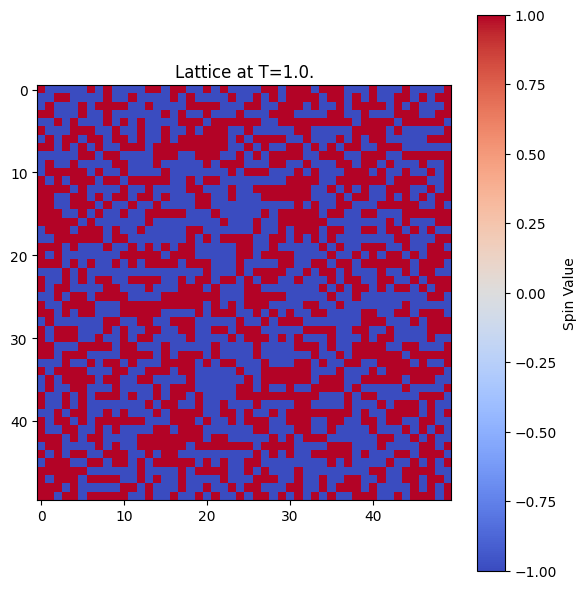

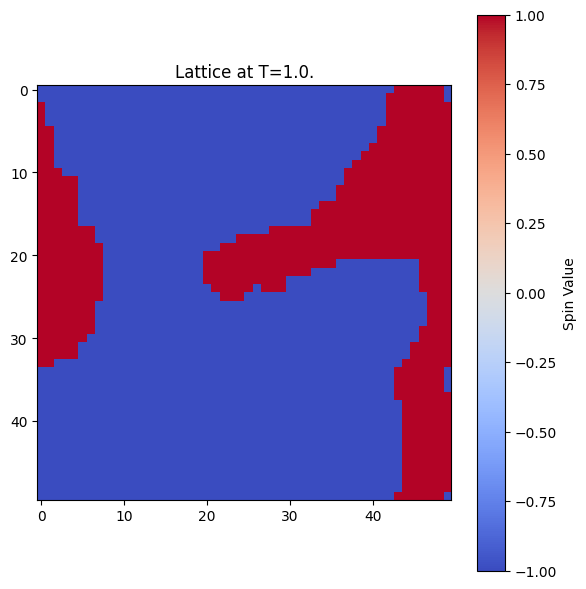

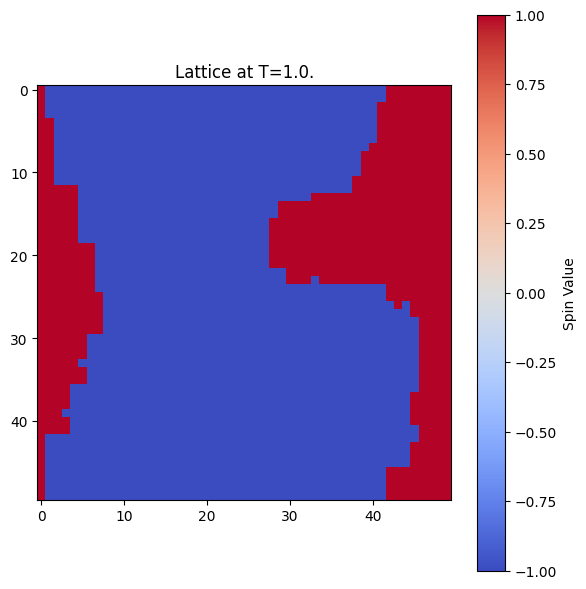

In [19]:
def generate_simple_lattice(L, init_condition, temp):
  """
  Generates a simple lattice for the plot.

  Args:
    L (int):              A lattice of the plot.
    init_condition (int): An init condition (1 for Hot and 0 for Cold).
    temp (float):         A current temperature of the system.

  Returns: numpy matrix.
  """
  return np.ones((L,L)) if init_condition == 0 else np.random.choice([-1, 1], (L,L))


def show_plot(L, data, temp):
  """
  Shows a plot for our config.

  Args:
    L (int):            A lattice of the plot.
    data (np.ndarray):  Numpy matrix of current state.
    temp (float):       A temperature.
  """
  plt.figure(figsize=(6,6))
  plt.title(f"Lattice at T={temp}.")

  plt.imshow(data, cmap='coolwarm')
  plt.colorbar(label = 'Spin Value')

  plt.tight_layout()
  plt.show()


def dynamic_states(L, init_condition, temp):
  """
  Produce an information about the dynamic states of the algorithm.

  Args:
    L (int):              A lattice of the plot.
    init_condition (int): An init condition (1 for Hot and 0 for Cold).
    temp (float):         A temperature.

  Raises:
    ValueError: If data type is mismatched.
  """
  # Validation start conditions.
  if not isinstance(L, int) or not isinstance(temp, float) or not isinstance(init_condition, int):
    raise ValueError("Lattice must be an int; init_condition must be an int; Temperature must be a float! Aborting...")
  if init_condition not in [0,1]:
    raise ValueError("init_condition must be an integer inside [0,1]!")


  # Generating latice.
  starting_state = generate_simple_lattice(L, init_condition, temp)


  # Visualizing the plot.
  show_plot(L, starting_state, temp)


  # Run metropolis_step for 100,000 steps and its visualizing after algorithm.
  lattice = metropolis_step(starting_state, temp, 100_000)
  show_plot(L, lattice, temp)

  # Run metropolis_step for 100,000 steps and its visualizing after algorithm.
  lattice = metropolis_step(lattice, temp, 100_000)
  show_plot(L, lattice, temp)


if __name__ == "__main__":
  dynamic_states(50, 1, 1.0)

**Task 2: Critical Temperature Check**

    Create a fresh random lattice.

    Set Temperature = 2.3 (This is near the Critical Point T_c ≈ 2.27).

    Run the simulation for 400,000 steps.

    Visualize.

    Goal: Describe what you see in the comments. Is it fully ordered? Is it pure noise? Or is it complex "fractal-like" structures?

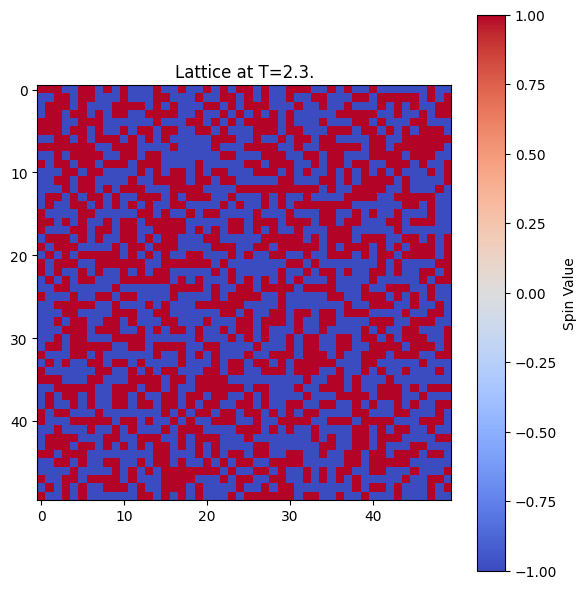

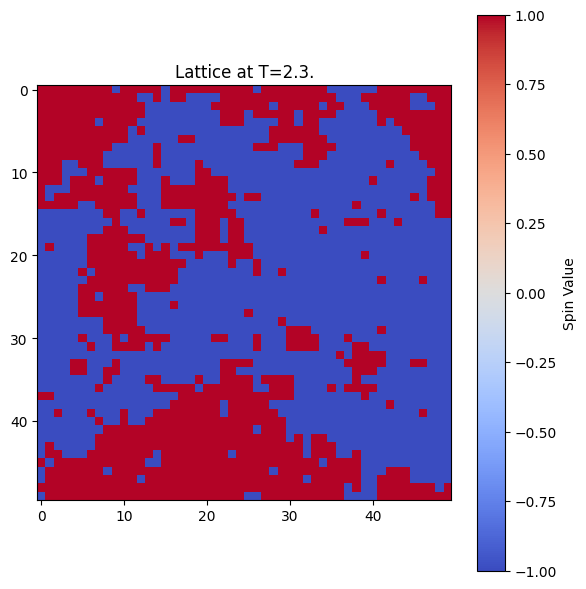

In [23]:
def generate_simple_lattice(L, temp):
  """
  Generates a simple lattice for the plot.

  Args:
    L (int):              A lattice of the plot.
    temp (float):         A current temperature of the system.

  Returns: numpy matrix.
  """
  return np.ones((L,L)) if temp < 2 else np.random.choice([-1, 1], (L,L))


def show_plot(L, data, temp):
  """
  Shows a plot for our config.

  Args:
    L (int):            A lattice of the plot.
    data (np.ndarray):  Numpy matrix of current state.
    temp (float):       A temperature.
  """
  plt.figure(figsize=(6,6))
  plt.title(f"Lattice at T={temp}.")

  plt.imshow(data, cmap='coolwarm')
  plt.colorbar(label = 'Spin Value')

  plt.tight_layout()
  plt.show()


def dynamic_states(L, temp):
  """
  Produce an information about the dynamic states of the algorithm.

  Args:
    L (int):              A lattice of the plot.
    temp (float):         A temperature.

  Raises:
    ValueError: If data type is mismatched.
  """
  # Validation start conditions.
  if not isinstance(L, int) or not isinstance(temp, float):
    raise ValueError("Lattice must be an int; Temperature must be a float! Aborting...")


  # Generating latice.
  starting_state = generate_simple_lattice(L, temp)


  # Visualizing the plot.
  show_plot(L, starting_state, temp)


  # Run metropolis_step for 400,000 steps and its visualizing after algorithm.
  lattice = metropolis_step(starting_state, temp, 400_000)
  show_plot(L, lattice, temp)


if __name__ == "__main__":
  dynamic_states(50, 2.3)

**Task 3: Data Generation Function**

Create a function simulate_ising(L, temp, steps) that:

    Creates a random lattice.

    Runs the simulation.

    Returns the final lattice.

*Note: This code might take 10-20 seconds to run. That's normal for pure Python*

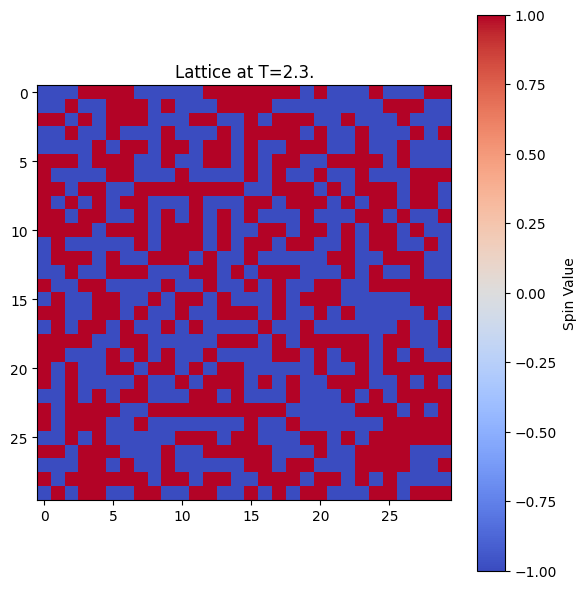

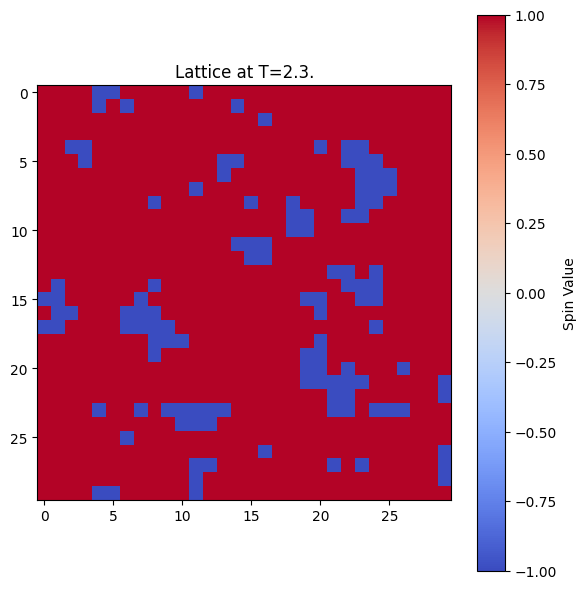

In [24]:
def generate_simple_lattice(L, temp):
  """
  Generates a simple lattice for the plot.

  Args:
    L (int):              A lattice of the plot.
    temp (float):         A current temperature of the system.

  Returns: (np.ndarray) numpy matrix.
  """
  return np.ones((L,L)) if temp < 2 else np.random.choice([-1, 1], (L,L))


def show_plot(L, data, temp):
  """
  Shows a plot for our config.

  Args:
    L (int):            A lattice of the plot.
    data (np.ndarray):  Numpy matrix of current state.
    temp (float):       A temperature.
  """
  plt.figure(figsize=(6,6))
  plt.title(f"Lattice at T={temp}.")

  plt.imshow(data, cmap='coolwarm')
  plt.colorbar(label = 'Spin Value')

  plt.tight_layout()
  plt.show()


def simulate_ising(L, temp, steps):
  """
  Creates a random lattice, runs a sim and finds the final lattice.

  Args:
    L (int):
    temp (float):
    steps (int):

  Raises:
    ValueError: If data type is mismatched.

  Returns: (np.ndarray) numpy matrix
  """
  # Validation start conditions.
  if not isinstance(L, int) or not isinstance(temp, float) or not isinstance(steps, int):
    raise ValueError("Lattice must be an int; Steps must be an int; Temperature must be a float! Aborting...")
  lattice = generate_simple_lattice(L, temp)
  show_plot(L, lattice, temp)
  lattice = metropolis_step(lattice, temp, steps)
  show_plot(L, lattice, temp)
  return lattice


if __name__ == "__main__":
  simulate_ising(30, 2.3, 1_000_000)